<a href="https://colab.research.google.com/github/nguyenhaidang94/HyperspectralImageClassification/blob/main/Hyperspectral_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spectral

In [ ]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import spectral as sptr

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Data viz

In [ ]:
def load_data():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  return X, y

data, labels = load_data()
print(data.shape)
print(labels.shape)

(145, 145, 200)
(145, 145)


ImageView object:
  Interpolation       :  <default>

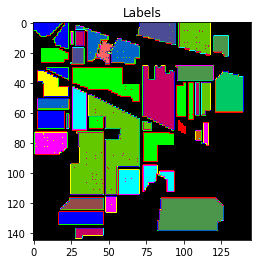

In [ ]:
sptr.imshow(classes=labels, title="Labels")

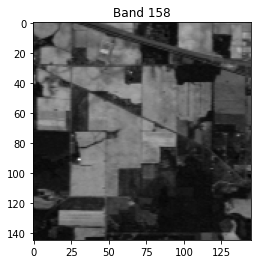

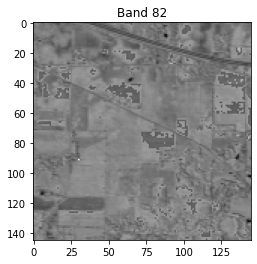

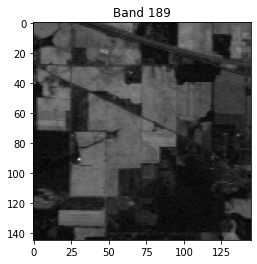

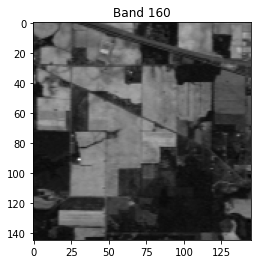

In [ ]:
n_samples = 4
sample_bands = np.random.randint(low=0, high=data.shape[2], size=n_samples)
for i in range(n_samples):
  sptr.imshow(data, bands=[sample_bands[i]], title=f"Band {sample_bands[i]}")

# Dimentionality Reduction

In [ ]:
from sklearn.decomposition import PCA
sns.set_theme()

Consider the data has 145x145 samples, each has 200 features.

In [ ]:
X = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
print(X.shape)

(21025, 200)


In [ ]:
list_ncomponents = np.arange(5, X.shape[1], 5)
explained_variances = []
for ncomponents in list_ncomponents:
  pca = PCA(n_components=ncomponents)
  pca.fit(X)
  explained_variances.append(np.sum(pca.explained_variance_ratio_))

[Text(0, 0.5, 'explained variance ratio'),
 Text(0.5, 0, 'n_components'),
 Text(0.5, 1.0, 'Explained variance per n_components')]

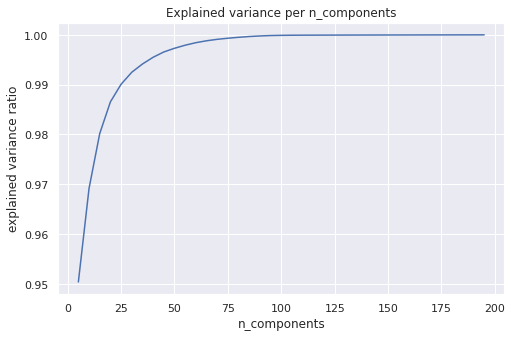

In [ ]:
plt.figure(figsize=(8, 5))
g = sns.lineplot(x=list_ncomponents, y=explained_variances)
g.set(title="Explained variance per n_components", xlabel="n_components",
      ylabel="explained variance ratio")

After n_components=25, the explained variance ratio slightly increased, we choose n_components=25.

# Baseline with Logistic Regression

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
sns.set_theme()

In [ ]:
X = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
y = labels.reshape((labels.shape[0] * labels.shape[1],))
print(X.shape, y.shape)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y,
                                                random_state=27)
print(Xtrain.shape, ytrain.shape)

(21025, 200) (21025,)
(14717, 200) (14717,)


In [ ]:
pca = PCA(n_components=25)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)
print(Xtrain_pca.shape)

(14717, 25)


In [ ]:
# Use gridsearch to select the best parameters
estimator = LogisticRegression(n_jobs=-1)
param_grid = {"C": [1, 5, 10]}
logit_clf = GridSearchCV(estimator=estimator, param_grid=param_grid,
                         scoring="f1_macro", n_jobs=-1, refit=True, cv=5)
logit_clf.fit(Xtrain_pca, ytrain)
print(f"Best params: {logit_clf.best_params_}")
print(f"Best score: {logit_clf.best_score_}")

Best params: {'C': 1}
Best score: 0.3602132130927536


In [ ]:
ytest_pred = logit_clf.predict(Xtest_pca)
print(classification_report(ytest, ytest_pred))

              precision    recall  f1-score   support

           0       0.82      0.68      0.75      3233
           1       0.00      0.00      0.00        14
           2       0.43      0.57      0.49       428
           3       0.56      0.21      0.30       249
           4       0.50      0.03      0.05        71
           5       0.68      0.50      0.58       145
           6       0.54      0.77      0.64       219
           7       0.00      0.00      0.00         8
           8       0.60      0.97      0.74       143
           9       0.00      0.00      0.00         6
          10       0.27      0.32      0.29       292
          11       0.44      0.84      0.58       737
          12       0.25      0.09      0.13       178
          13       0.69      0.85      0.76        61
          14       0.40      0.41      0.41       380
          15       0.00      0.00      0.00       116
          16       0.42      0.54      0.47        28

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The performance is low.

# XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
X = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
y = labels.reshape((labels.shape[0] * labels.shape[1],))
print(X.shape, y.shape)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y,
                                                random_state=27)
print(Xtrain.shape, ytrain.shape)

(21025, 200) (21025,)
(14717, 200) (14717,)


In [ ]:
# tune number of trees and max depth
estimator = xgb.XGBClassifier(learning_rate=0.1, objective="multi:softmax",
                              n_jobs=-1, tree_method="gpu_hist")
param_grid = {"n_estimators": [50, 100, 150], "max_depth": [5, 7, 9]}
gridsearch = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5,
                          scoring="f1_macro", n_jobs=-1, refit=False)
gridsearch.fit(Xtrain, ytrain)
print(f"Best params: {gridsearch.best_params_}")
print(f"Best score: {gridsearch.best_score_}")

In [ ]:
# tune learning rate and regularization
estimator = xgb.XGBClassifier(n_estimators=150, max_depth=7,
                              objective="multi:softmax", n_jobs=-1,
                              tree_method="gpu_hist")
param_grid = {"learning_rate": [0.1, 0.2, 0.3], "reg_lambda": [1, 3, 5, 7]}
gridsearch = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5,
                          scoring="f1_macro", n_jobs=-1, refit=False)
gridsearch.fit(Xtrain, ytrain)
print(f"Best params: {gridsearch.best_params_}")
print(f"Best score: {gridsearch.best_score_}")

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=150, max_depth=7, learning_rate=0.2,
                            reg_lambda=5, objective="multi:softmax", n_jobs=-1,
                            tree_method="gpu_hist")
xgb_clf.fit(Xtrain, ytrain)
ytest_pred = xgb_clf.predict(Xtest)
print(classification_report(ytest, ytest_pred))

The performance is much better.

In [ ]:
feature_importances = xgb_clf.feature_importances_
plt.figure(figsize=(19,5))
g = sns.barplot(y=feature_importances, x=np.arange(len(feature_importances)))
g.set(title="Feature importances")
for idx, label in enumerate(g.get_xticklabels()):
  if idx % 10 == 0:  # every 10th label is kept
    label.set_visible(True)
  else:
    label.set_visible(False)

In [ ]:
sptr.imshow(classes=labels, title="Labels")

In [ ]:
n_features = 5
print(f"Top {n_features} features:")
top_nfeatures = np.argsort(feature_importances)[::-1][:n_features]
for f in top_nfeatures:
  sptr.imshow(data, bands=[f], title=f"Band {f}")

These features can visibly distinguish the classes.

In [ ]:
# calculate the predicted image
ypred = xgb_clf.predict(X)
ypred = ypred.reshape(labels.shape)
sptr.imshow(classes=ypred, title="Predicted labels")
sptr.imshow(classes=labels, title="True labels")

# Residual net

In [ ]:
from sklearn.decomposition import PCA
from keras import backend as K
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.initializers import glorot_uniform
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

sns.set_theme()

In [ ]:
def pad_zeros(X, margin):
  X_padded = np.zeros((X.shape[0] + 2*margin,
                       X.shape[1] + 2*margin, X.shape[2]))
  x_offset = margin
  y_offset = margin
  X_padded[x_offset : X.shape[0]+x_offset, y_offset : X.shape[1]+y_offset, :] = X
  return X_padded

def create_image_patches(X, y, window_size):
  # window size is an odd
  margin = int((window_size) / 2)
  X_padded = pad_zeros(X, margin)
  # split patches
  X_patches = np.zeros((X.shape[0]*X.shape[1], window_size, window_size,
                        X.shape[2]))
  y_patches = np.zeros((y.shape[0] * y.shape[1]))
  patch_idx = 0
  for r in range(margin, X_padded.shape[0]-margin):
    for c in range(margin, X_padded.shape[1]-margin):
      patch = X_padded[r-margin : r+margin+1, c-margin : c+margin+1]   
      X_patches[patch_idx, :, :, :] = patch
      y_patches[patch_idx] = y[r-margin, c-margin]
      patch_idx += 1
  return X_patches, y_patches

def preprocess(data, labels, latent_dims, window_size):
  X = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
  pca = PCA(n_components=latent_dims)
  X_pca = pca.fit_transform(X)
  X_pca = X_pca.reshape((data.shape[0], data.shape[1], latent_dims))
  X_batches, y_batches = create_image_patches(X_pca, labels, window_size)
  y_batches = np_utils.to_categorical(y_batches)
  return X_batches, y_batches

In [ ]:
# window size is an odd
window_size = 13
latent_dims = 25
X, y = preprocess(data, labels, latent_dims, window_size)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, stratify=y)
Xtest, Xval, ytest, yval = train_test_split(Xtest, ytest, test_size=0.5,
                                            stratify=ytest)                                                
print("Train set:", Xtrain.shape, ytrain.shape)
print("Test set:", Xtest.shape, ytest.shape)
print("Val set:", Xval.shape, yval.shape)

Train set: (10512, 13, 13, 25) (10512, 17)
Test set: (5256, 13, 13, 25) (5256, 17)
Val set: (5257, 13, 13, 25) (5257, 17)


In [ ]:
def identity_block(X, kernel_size, filters, stage, block):
  conv_name_base = f"res{stage}{block}_branch"
  bn_name_base = f"bn{stage}{block}_branch"
  F1, F2 = filters
  X_shortcut = X
  
  X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid',
             name=conv_name_base + '2a', kernel_initializer=glorot_uniform())(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=F2, kernel_size=kernel_size, strides=1, padding='same',
             name=conv_name_base + '2b', kernel_initializer=glorot_uniform())(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

  X = Add()([X, X_shortcut])# SKIP Connection
  X = Activation('relu')(X)

  return X

def convolutional_block(X, kernel_size, filters, stage, block, strides):
  conv_name_base = f"res{stage}{block}_branch"
  bn_name_base = f"bn{stage}{block}_branch"
  F1, F2 = filters
  X_shortcut = X

  X = Conv2D(filters=F1, kernel_size=1, strides=strides, padding='valid',
             name=conv_name_base + '2a', kernel_initializer=glorot_uniform())(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=F2, kernel_size=kernel_size, strides=1, padding='same',
             name=conv_name_base + '2b', kernel_initializer=glorot_uniform())(X)
  X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)

  X_shortcut = Conv2D(filters=F2, kernel_size=1, strides=strides,
                      padding='valid', name=conv_name_base + '1',
                      kernel_initializer=glorot_uniform())(X_shortcut)
  X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

def ResNet(input_shape, output_units):
  X_input = Input(input_shape)

  X = Conv2D(kernel_size=3, filters=64, strides=1, name='conv1',
             kernel_initializer=glorot_uniform())(X_input)
  X = BatchNormalization(axis=3, name='bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=2, strides=2)(X)

  X = convolutional_block(X, kernel_size=3, filters=[64, 64], stage=2, block='a', strides=1)
  X = identity_block(X, kernel_size=3, filters=[64, 64], stage=2, block='b')

  X = convolutional_block(X, kernel_size=3, filters=[128, 128], stage=3, block='a', strides=1)
  X = identity_block(X, 3, [128, 128], stage=3, block='b')

  X = convolutional_block(X, kernel_size=3, filters=[256, 256], stage=4, block='a', strides=1)
  X = identity_block(X, 3, [256, 256], stage=4, block='b')

  X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
  X = Flatten()(X)
  X = Dense(32, activation="relu")(X)
  X_output = Dense(output_units, activation="softmax")(X)
  
  model = Model(inputs=X_input, outputs=X_output, name='ResNet')

  return model

In [ ]:
input_shape = (window_size, window_size, X.shape[3])
output_units = y.shape[1]
model = ResNet(input_shape, output_units)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 13, 13, 25)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 11, 11, 64)   14464       input_7[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 11, 11, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_67 (Activation)      (None, 11, 11, 64)   0           bn_conv1[0][0]                   
_____________________________________________________________________________________________

In [ ]:
filepath = "checkpoints/resnet-best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', mode='min',
                             save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(Xtrain, ytrain, batch_size=32, epochs=30,
                    validation_data=(Xval, yval), callbacks=callbacks_list)

Epoch 1/30
329/329 [==============================] - 43s 36ms/step - loss: 0.9553 - accuracy: 0.6942 - val_loss: 0.6025 - val_accuracy: 0.7974
Epoch 2/30
329/329 [==============================] - 9s 29ms/step - loss: 0.4147 - accuracy: 0.8596 - val_loss: 0.3012 - val_accuracy: 0.8958
Epoch 3/30
329/329 [==============================] - 10s 29ms/step - loss: 0.2883 - accuracy: 0.9031 - val_loss: 0.2045 - val_accuracy: 0.9252
Epoch 4/30
329/329 [==============================] - 11s 33ms/step - loss: 0.2025 - accuracy: 0.9308 - val_loss: 0.2050 - val_accuracy: 0.9268
Epoch 5/30
329/329 [==============================] - 10s 29ms/step - loss: 0.1605 - accuracy: 0.9443 - val_loss: 0.2427 - val_accuracy: 0.9241
Epoch 6/30
329/329 [==============================] - 10s 29ms/step - loss: 0.1238 - accuracy: 0.9568 - val_loss: 0.1932 - val_accuracy: 0.9389
Epoch 7/30
329/329 [==============================] - 10s 29ms/step - loss: 0.1110 - accuracy: 0.9621 - val_loss: 0.1484 - val_accuracy: 

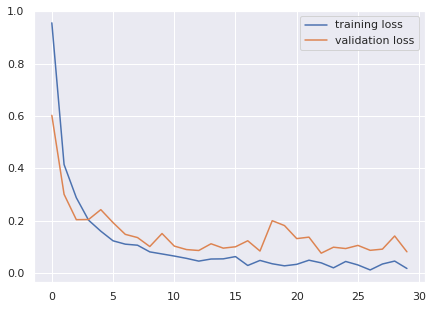

In [ ]:
training_loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(7, 5))
plt.plot(training_loss, label="training loss")
plt.plot(val_loss, label="validation loss")
plt.legend()

In [ ]:
model.load_weights("checkpoints/resnet-best-model.hdf5")
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
results = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(results)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2694
           1       1.00      0.92      0.96        12
           2       0.99      0.95      0.97       357
           3       0.99      0.99      0.99       207
           4       0.98      0.97      0.97        59
           5       0.99      0.97      0.98       121
           6       0.95      0.99      0.97       182
           7       1.00      0.86      0.92         7
           8       0.99      0.97      0.98       120
           9       0.62      1.00      0.77         5
          10       0.99      0.99      0.99       243
          11       0.98      1.00      0.99       614
          12       0.94      0.98      0.96       148
          13       0.98      1.00      0.99        51
          14       0.99      1.00      0.99       316
          15       0.98      0.99      0.98        97
          16       1.00      0.91      0.95        23

    accuracy              

A good performance from Resnet.

ImageView object:
  Interpolation       :  <default>

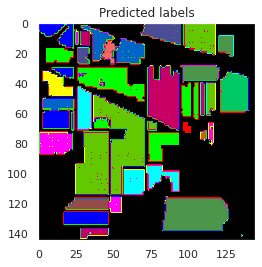

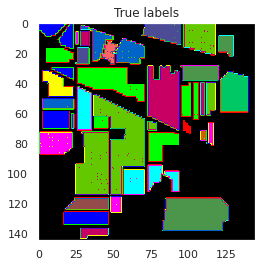

In [ ]:
# calculate the predicted image
ypred = model.predict(X)
ypred = np.argmax(ypred, axis=1)
ypred = ypred.reshape(labels.shape)
sptr.imshow(classes=ypred, title="Predicted labels")
sptr.imshow(classes=labels, title="True labels")

# SpectralNet

In [ ]:
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras import backend as Kb
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, Dropout, Input, Lambda, Activation, AveragePooling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model

In [ ]:
def applyFA(X, numComponents=75):
  newX = np.reshape(X, (-1, X.shape[2]))
  fa = FactorAnalysis(n_components=numComponents, random_state=0)
  newX = fa.fit_transform(newX)
  newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
  return newX, fa

def padWithZeros(X, margin=2):
  newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
  x_offset = margin
  y_offset = margin
  newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
  return newX

def createImageCubes(X, y, windowSize=8, removeZeroLabels=True):
  margin = int((windowSize) / 2)
  zeroPaddedX = padWithZeros(X, margin=margin)
  # split patches
  patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
  patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
  patchIndex = 0
  for r in range(margin, zeroPaddedX.shape[0] - margin):
    for c in range(margin, zeroPaddedX.shape[1] - margin):
      patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
      patchesData[patchIndex, :, :, :] = patch
      patchesLabels[patchIndex] = y[r-margin, c-margin]
      patchIndex = patchIndex + 1
  if removeZeroLabels:
    patchesData = patchesData[patchesLabels>0,:,:,:]
    patchesLabels = patchesLabels[patchesLabels>0]
    patchesLabels -= 1
  return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio,
                                                      stratify=y)
  return X_train, X_test, y_train, y_test

In [ ]:
K = 3
windowSize = 24
test_ratio = 0.7
X,_ = applyFA(data, numComponents=K)
print(X.shape)
X, y = createImageCubes(X, labels, windowSize=windowSize)
print(X.shape, y.shape)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
print(Xtrain.shape, Xtest.shape)
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
ytrain = np_utils.to_categorical(ytrain)
print(Xtrain.shape, ytrain.shape)

(145, 145, 3)
(10249, 24, 24, 3) (10249,)
(3074, 24, 24, 3) (7175, 24, 24, 3)
(3074, 24, 24, 3, 1) (3074, 16)


In [ ]:
# wavelet transform
def WaveletTransformAxisY(batch_img):
  odd_img  = batch_img[:,0::2]
  even_img = batch_img[:,1::2]
  L = (odd_img + even_img) / 2.0
  H = Kb.abs(odd_img - even_img)
  return L, H

def WaveletTransformAxisX(batch_img):
  # transpose + fliplr
  tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
  _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
  # transpose + flipud
  dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
  dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
  return dst_L, dst_H

def Wavelet(batch_image):
  # make channel first image
  batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
  r = batch_image[:,0]
  g = batch_image[:,1]
  b = batch_image[:,2]

  # level 1 decomposition
  wavelet_L, wavelet_H = WaveletTransformAxisY(r)
  r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
  r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

  wavelet_L, wavelet_H = WaveletTransformAxisY(g)
  g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
  g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

  wavelet_L, wavelet_H = WaveletTransformAxisY(b)
  b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
  b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

  wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                  g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                  b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
  transform_batch = Kb.stack(wavelet_data, axis=1)

  # level 2 decomposition
  wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
  r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
  r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

  wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
  g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
  g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

  wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
  b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
  b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)


  wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2,
                     g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                     b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
  transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

  # level 3 decomposition
  wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
  r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
  r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

  wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
  g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
  g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

  wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
  b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
  b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

  wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                     g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                     b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
  transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

  # level 4 decomposition
  wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
  r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
  r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

  wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
  g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
  g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

  wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL3)
  b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
  b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)


  wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                  g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                  b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
  transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

  # print('shape before')
  # print(transform_batch.shape)
  # print(transform_batch_l2.shape)
  # print(transform_batch_l3.shape)
  # print(transform_batch_l4.shape)

  decom_level_1 = Kb.permute_dimensions(transform_batch, [0, 2, 3, 1])
  decom_level_2 = Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1])
  decom_level_3 = Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1])
  decom_level_4 = Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1])
  
  # print('shape after')
  # print(decom_level_1.shape)
  # print(decom_level_2.shape)
  # print(decom_level_3.shape)
  # print(decom_level_4.shape)
  return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]

def Wavelet_out_shape(input_shapes):
  return [tuple([None, 12, 12, 12]), tuple([None, 6, 6, 12]), 
          tuple([None, 3, 3, 12]), tuple([None, 2, 2, 12])]

In [ ]:
img_batch = Kb.zeros(shape=(3074, 24, 24, 3), dtype='float32')
results = Wavelet(img_batch)

shape before
(3074, 12, 12, 12)
(3074, 12, 6, 6)
(3074, 12, 3, 3)
(3074, 12, 2, 2)
shape after
(3074, 12, 12, 12)
(3074, 6, 6, 12)
(3074, 3, 3, 12)
(3074, 2, 2, 12)


In [ ]:
def get_wavelet_cnn_model(input_shape, output_units):
  input_ = Input(input_shape, name='the_input')
  wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
  input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
  # level one decomposition starts
  conv_1 = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_1')(input_l1)
  norm_1 = BatchNormalization(name='norm_1')(conv_1)
  relu_1 = Activation('relu', name='relu_1')(norm_1)

  conv_1_2 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_1_2')(relu_1)
  norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
  relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

  # level two decomposition starts
  conv_a = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_a')(input_l2)
  norm_a = BatchNormalization(name='norm_a')(conv_a)
  relu_a = Activation('relu', name='relu_a')(norm_a)

  # concate level one and level two decomposition
  concate_level_2 = concatenate([relu_1_2, relu_a])
  conv_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_2')(concate_level_2)
  norm_2 = BatchNormalization(name='norm_2')(conv_2)
  relu_2 = Activation('relu', name='relu_2')(norm_2)

  conv_2_2 = Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_2_2')(relu_2)
  norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
  relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

  # level three decomposition starts 
  conv_b = Conv2D(filters=64, kernel_size=(3, 3), padding='same', name='conv_b')(input_l3)
  norm_b = BatchNormalization(name='norm_b')(conv_b)
  relu_b = Activation('relu', name='relu_b')(norm_b)

  conv_b_2 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_b_2')(relu_b)
  norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
  relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

  # concate level two and level three decomposition 
  concate_level_3 = concatenate([relu_2_2, relu_b_2])
  conv_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_3')(concate_level_3)
  norm_3 = BatchNormalization(name='nomr_3')(conv_3)
  relu_3 = Activation('relu', name='relu_3')(norm_3)

  conv_3_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_3_2')(relu_3)
  norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
  relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

  # level four decomposition start
  conv_c = Conv2D(64, kernel_size=(3, 3), padding='same', name='conv_c')(input_l4)
  norm_c = BatchNormalization(name='norm_c')(conv_c)
  relu_c = Activation('relu', name='relu_c')(norm_c)

  conv_c_2 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_2')(relu_c)
  norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
  relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

  conv_c_3 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_c_3')(relu_c_2)
  norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
  relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

  # concate level level three and level four decomposition
  concate_level_4 = concatenate([relu_3_2, relu_c_3])
  conv_4 = Conv2D(256, kernel_size=(3, 3), padding='same', name='conv_4')(concate_level_4)
  norm_4 = BatchNormalization(name='norm_4')(conv_4)
  relu_4 = Activation('relu', name='relu_4')(norm_4)

  conv_4_2 = Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', name='conv_4_2')(relu_4)
  norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
  relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

  conv_5_1 = Conv2D(128, kernel_size=(3, 3), padding='same', name='conv_5_1')(relu_4_2)
  norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
  relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)

  pool_5_1 = AveragePooling2D(pool_size=(7, 7), strides=1, padding='same', name='avg_pool_5_1')(relu_5_1)
  flatten_layer = Flatten()(pool_5_1)

  dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
  dense_layer1 = Dropout(0.4)(dense_layer1)
  dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
  dense_layer2 = Dropout(0.4)(dense_layer2)
  output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

  model = Model(inputs=input_, outputs=output_layer)
  return model

In [ ]:
input_shape = (windowSize, windowSize, K)
output_units = ytrain.shape[1]
model = get_wavelet_cnn_model(input_shape, output_units)
model.summary()
# plot_model(model, to_file='wavelet_cnn.png')

shape before
(None, 12, 12, 12)
(None, 12, 6, 6)
(None, 12, 3, 3)
(None, 12, 2, 2)
shape after
(None, 12, 12, 12)
(None, 6, 6, 12)
(None, 3, 3, 12)
(None, 2, 2, 12)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
wavelet (Lambda)                [(None, 12, 12, 12), 0           the_input[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 12, 12, 64)   6976        wavelet[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization

In [ ]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
filepath = "checkpoints/best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', mode='min', save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=30, epochs=30, callbacks=callbacks_list)

Epoch 1/30
shape before
(None, 12, 12, 12)
(None, 12, 6, 6)
(None, 12, 3, 3)
(None, 12, 2, 2)
shape after
(None, 12, 12, 12)
(None, 6, 6, 12)
(None, 3, 3, 12)
(None, 2, 2, 12)
shape before
(None, 12, 12, 12)
(None, 12, 6, 6)
(None, 12, 3, 3)
(None, 12, 2, 2)
shape after
(None, 12, 12, 12)
(None, 6, 6, 12)
(None, 3, 3, 12)
(None, 2, 2, 12)
103/103 [==============================] - 8s 48ms/step - loss: 1.0159 - accuracy: 0.6874
Epoch 2/30
103/103 [==============================] - 4s 43ms/step - loss: 0.3114 - accuracy: 0.9115
Epoch 3/30
103/103 [==============================] - 4s 42ms/step - loss: 0.1688 - accuracy: 0.9532
Epoch 4/30
103/103 [==============================] - 4s 40ms/step - loss: 0.0663 - accuracy: 0.9811
Epoch 5/30
103/103 [==============================] - 4s 37ms/step - loss: 0.0719 - accuracy: 0.9792
Epoch 6/30
103/103 [==============================] - 4s 36ms/step - loss: 0.0597 - accuracy: 0.9841
Epoch 7/30
103/103 [==============================] - 4s 36ms/st

[Text(0.5, 1.0, 'Loss per epoch')]

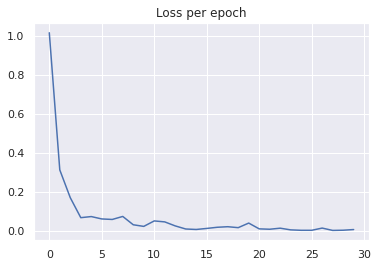

In [ ]:
g = sns.lineplot(x=range(len(history.history["loss"])), y=history.history["loss"])
g.set(title="Loss per epoch")

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
ytest = np_utils.to_categorical(ytest)
print(Xtest.shape, ytest.shape)

(7175, 24, 24, 3, 1) (7175, 16)


In [ ]:
model.load_weights("checkpoints/best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)
results = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(results)

shape before
(None, 12, 12, 12)
(None, 12, 6, 6)
(None, 12, 3, 3)
(None, 12, 2, 2)
shape after
(None, 12, 12, 12)
(None, 6, 6, 12)
(None, 3, 3, 12)
(None, 2, 2, 12)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      0.99      1.00      1000
           2       1.00      1.00      1.00       581
           3       0.99      1.00      0.99       166
           4       1.00      1.00      1.00       338
           5       1.00      1.00      1.00       511
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00       335
           8       1.00      1.00      1.00        14
           9       1.00      0.99      1.00       680
          10       1.00      1.00      1.00      1719
          11       1.00      0.99      0.99       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       0.99 